In [2]:
import numpy as np
import scipy as ci 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML
from sklearn.externals import joblib

import seaborn as sns 
import tables 
import pickle
import warnings
warnings.filterwarnings('once')

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

/Users/yang/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 12})
plt.rc('axes', axisbelow=True)

<Figure size 432x288 with 0 Axes>

In [4]:
lifetime = 86400*365 # 1 year! 
fig_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/plots/ana-2-2-'
data_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/'
plt.rcParams.update({'font.size': 14})
plt.rc('axes', axisbelow=True)

In [5]:
# # OLD and NEW ineff model parameters 
# params_new = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model_new.txt')
# def ineff_model_new(dist,E): # E: log10 of energy!!! 

#     a = params_new[0] + params_new[2] * (E + params_new[1])**2
#     b = params_new[3] + params_new[4]*E
#     c = params_new[5] + params_new[6]*E
#     val = a * 1 / (1+np.exp(-(dist/2000-b)/c))

#     val[val < 1e-5] = 1e-5 # This is arbitrary! 

#     # low stat cut 
#     val[E > 5.4+1.8*np.sqrt(1 - (dist)**2/2200**2)]=1
#     val[dist>2200]=1
# #     val[E<4.7]=0.7
# #     val[E<3/500*dist + 3-3/500*200]=0.7
#     return val

# xt = np.linspace(0.001,3000,100) # dist 
# yt = np.linspace(5.5,7,100)  # E 
# xg,yg = np.meshgrid(xt,yt)
# zg = ineff_model_new(xg,yg)

# plt.figure(figsize=(7,5))
# plt.pcolormesh(xg,yg,zg,cmap='rainbow',shading='flat')
# plt.colorbar()
# plt.clim(0,1) # colorbar limit
# CS=plt.contour(xg,yg,zg,levels=[0.001,0.005,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
# plt.clabel(CS,inline=1,fmt='%1.3f',fontsize=6)
# plt.xlabel('distance to center of IT [m]')
# plt.ylabel('log(truncated muon energy)')
# plt.xlim(0,3000)
# plt.ylim(5.5,7)
# plt.title('New IT Ineff Model using 2 pulses')
# plt.show()

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


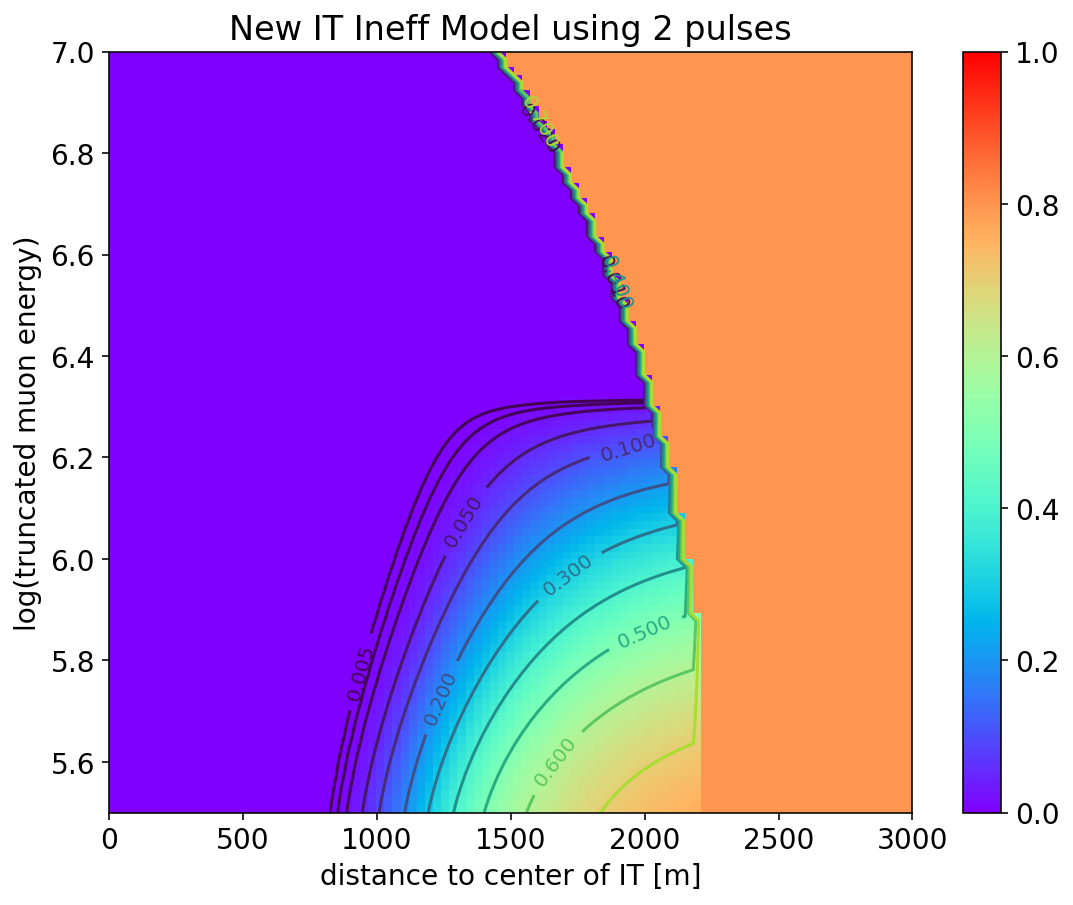

In [6]:
# OLD and NEW ineff model parameters 
params = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model.txt')
def ineff_model_new(dist,E): # E: log10 of energy!!! 
    
    a = params[0] * (E - params[1])**2 + params[2]
    b = params[3] * (E - params[4])**2 + params[5]
    
#     val = a * 1 / (1+np.exp(-(dist/2000-b)/c))
    val = a * np.exp(-b/(dist/2000)**(4.5))

    val[val < 1e-5] = 1e-5 # This is arbitrary! 

    # low stat cut 
    
    val[E > 5.47+2*np.sqrt(1 - ((dist-20)/2210)**2) ]=0.8
    val[dist > 2210] = 0.8
    return val

xt = np.linspace(0.001,3000,100) # dist 
yt = np.linspace(5.5,7,100)  # E 
xg,yg = np.meshgrid(xt,yt)
zg = ineff_model_new(xg,yg)

plt.figure(figsize=(9,7))
plt.pcolormesh(xg,yg,zg,cmap='rainbow',shading='flat')
plt.colorbar()
plt.clim(0,1) # colorbar limit
CS=plt.contour(xg,yg,zg,levels=[0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
plt.clabel(CS,inline=1,fmt='%1.3f',fontsize=10)
plt.xlabel('distance to center of IT [m]')
plt.ylabel('log(truncated muon energy)')
plt.xlim(0,3000)
plt.ylim(5.5,7)
plt.title('New IT Ineff Model using 2 pulses')
plt.show()

In [7]:
ineffcut = 0.01

In [8]:
with tables.open_file(data_dir+'corsika_h5/corsika_combined.h5','r') as f:

    ineff_ = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
    CUT_ineff = ineff_ < ineffcut
    
    CUT_goodweight = f.root.Combined_Weight_H3a[:] > 0
    
    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_ineff & CUT_goodweight
    
    chi2_corsika = f.root.Collection.cols.chi2[:][CUT]
    chi2_red_corsika = f.root.Collection.cols.chi2_red[:][CUT]
    stoch_corsika = f.root.Collection.cols.stoch[:][CUT]
    chi2_new_corsika = f.root.Collection.cols.chi2_new[:][CUT]
    chi2_red_new_corsika = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_corsika = f.root.Collection.cols.PeakOverMedian[:][CUT]
    PeakOverMean_corsika = f.root.Collection.cols.PeakOverMean[:][CUT]

    zenith_corsika = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_corsika = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_corsika = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_corsika = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_corsika = f.root.QTot.cols.value[:][CUT]
    Qtot_corsika = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_corsika = f.root.Balloon.cols.N_Doms[:][CUT]
    N_pulses_corsika = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_corsika = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
    balloon_adjusted_corsika = f.root.Balloon.cols.InIceBalloonParameter_adjusted[:][CUT]
    in_ice_total_charge_corsika = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    in_ice_total_charge_reduced_corsika = f.root.Balloon.cols.InIceTotalCharge_reduced[:][CUT]
    ndirdoms_corsika = f.root.SplineMPEDirectHitsC.cols.n_dir_doms[:][CUT]
    ndirpulses_corsika = f.root.SplineMPEDirectHitsC.cols.n_dir_pulses[:][CUT]
    topocount_corsika = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
    wimpcount_corsika = f.root.WIMPrecoTopoSplitSplitCount.cols.value[:][CUT]
    cv_ndoms_corsika = f.root.CVMultiplicity.cols.n_hit_doms[:][CUT]
    cv_npulses_corsika = f.root.CVMultiplicity.cols.n_pulses[:][CUT]
    
    closest_d_corsika = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_corsika = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_corsika = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_corsika = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
#     coincident_corsika = f.root.MCPrimary_coincident.cols.value[:][CUT]
    prim_e_corsika = f.root.PolyplopiaPrimary.cols.energy[:][CUT]
    
    E_bundle_corsika = f.root.Bundle.cols.MuonBundleEnergy_Ei[:][CUT]
    E_leading_muon_corsika = f.root.Bundle.cols.MostEnergeticMuonEnergy_i[:][CUT]
    singleness_corsika = f.root.Bundle.cols.Singleness_Ei[:][CUT]
    bsize_corsika = f.root.Bundle.cols.Size_Ei[:][CUT]
    xf_corsika = E_bundle_corsika/prim_e_corsika
    E_shower_corsika = prim_e_corsika - E_bundle_corsika # surface shower
    
    runid_corsika = f.root.FileNumber.cols.value[:][CUT]
    eventid_corsika = f.root.FileNumber.cols.Event[:][CUT]
    
    A_corsika = f.root.PolyplopiaPrimary.cols.type[:][CUT]
    CUT_H = A_corsika == 2212
    CUT_He = A_corsika == 1000020040
    CUT_N= A_corsika == 1000070140
    CUT_Al = A_corsika == 1000130270
    CUT_Fe = A_corsika == 1000260560
    
    weight_corsika = f.root.Combined_Weight_H3a[:][CUT] * lifetime 

    weight_corsika_H = np.sum(weight_corsika) * weight_corsika[CUT_H]/np.sum(weight_corsika[CUT_H])
    weight_corsika_He = np.sum(weight_corsika) * weight_corsika[CUT_He]/np.sum(weight_corsika[CUT_He])
    weight_corsika_N = np.sum(weight_corsika) * weight_corsika[CUT_N]/np.sum(weight_corsika[CUT_N])
    weight_corsika_Al = np.sum(weight_corsika) * weight_corsika[CUT_Al]/np.sum(weight_corsika[CUT_Al])
    weight_corsika_Fe = np.sum(weight_corsika) * weight_corsika[CUT_Fe]/np.sum(weight_corsika[CUT_Fe])

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


In [9]:
with tables.open_file(data_dir+'data_h5/data_burn.h5','r') as f:
    nfile_data = [2831731.134,3081951.304,3158084.037,3155703.188,3082765.564]

    ineff_ = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
    CUT_ineff = ineff_ < ineffcut
    
    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_ineff
    
    chi2_data_burn = f.root.Collection.cols.chi2[:][CUT]
    chi2_red_data_burn = f.root.Collection.cols.chi2_red[:][CUT]
    chi2_new_data_burn = f.root.Collection.cols.chi2_new[:][CUT]
    chi2_red_new_data_burn = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:][CUT]
    PeakOverMean_data_burn = f.root.Collection.cols.PeakOverMean[:][CUT]
    stoch_data_burn = (chi2_red_data_burn + (np.log10(PeakOverMedian_data_burn)/2))/np.sqrt(2)
    stoch_new_data_burn = np.log10(chi2_red_new_data_burn)/8 + np.log10(PeakOverMedian_data_burn)
    
    zenith_data_burn = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_data_burn = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_data_burn = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_data_burn = f.root.QTot.cols.value[:][CUT]
    Qtot_data_burn = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_data_burn = f.root.Balloon.cols.N_Doms[:][CUT]
    N_pulses_data_burn = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_data_burn = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
    balloon_adjusted_data_burn = f.root.Balloon.cols.InIceBalloonParameter_adjusted[:][CUT]
    in_ice_total_charge_data_burn = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    in_ice_total_charge_reduced_data_burn = f.root.Balloon.cols.InIceTotalCharge_reduced[:][CUT]
    ndirdoms_data_burn = f.root.SplineMPEDirectHitsC.cols.n_dir_doms[:][CUT]
    ndirpulses_data_burn = f.root.SplineMPEDirectHitsC.cols.n_dir_pulses[:][CUT]
    topocount_data_burn = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
    wimpcount_data_burn = f.root.WIMPrecoTopoSplitSplitCount.cols.value[:][CUT]
    cv_ndoms_data_burn = f.root.CVMultiplicity.cols.n_hit_doms[:][CUT]
    cv_npulses_data_burn = f.root.CVMultiplicity.cols.n_pulses[:][CUT]

    closest_d_data_burn = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_data_burn = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_data_burn = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_data_burn = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]

    IT_Npulse_data_burn = f.root.IT_veto_double.cols.num_Total_hits[:][CUT]
    Npulse_in_window_data_burn = f.root.IT_veto_double.cols.num_correlated_Total_hits_in_window[:][CUT]
    Npulse_off_window_data_burn = f.root.IT_veto_double.cols.num_correlated_Total_hits_off_window[:][CUT]

    passed_2_data_burn = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # 1 if passed 
    vetoed_2_data_burn = (1 - f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 

    # if use IT TW cleaning
    
#     IT_Npulse_data_burn = f.root.IT_veto_double_TW.cols.num_Total_hits[:][CUT]
#     Npulse_in_window_data_burn = f.root.IT_veto_double_TW.cols.num_correlated_Total_hits_in_window[:][CUT]
#     Npulse_off_window_data_burn = f.root.IT_veto_double_TW.cols.num_correlated_Total_hits_off_window[:][CUT]

#     passed_2_data_burn = (f.root.IT_veto_double_TW.cols.flag_window_2[:][CUT]).astype(bool) # 1 if passed 
#     vetoed_2_data_burn = (1 - f.root.IT_veto_double_TW.cols.flag_window_2[:][CUT]).astype(bool) 

    
    runid_data_burn = f.root.I3EventHeader.cols.Run[:][CUT]
    eventid_data_burn = f.root.I3EventHeader.cols.Event[:][CUT]

    weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(zenith_data_burn))


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


In [10]:
with tables.open_file(data_dir+'nugen_h5/nugen_20878.h5','r') as f:
    n_file = 10000

    ineff_ = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
    CUT_ineff = ineff_ < ineffcut

    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_ineff
    
    chi2_numu = f.root.Collection.cols.chi2[:][CUT]
    chi2_red_numu = f.root.Collection.cols.chi2_red[:][CUT]
    stoch_numu = f.root.Collection.cols.stoch[:][CUT]
    chi2_new_numu = f.root.Collection.cols.chi2_new[:][CUT]
    chi2_red_new_numu = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_numu = f.root.Collection.cols.PeakOverMedian[:][CUT]
    PeakOverMean_numu = f.root.Collection.cols.PeakOverMean[:][CUT]

    zenith_numu = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_numu = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_numu = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_numu = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_numu = f.root.QTot.cols.value[:][CUT]
    Qtot_numu = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_numu = f.root.Balloon.cols.N_Doms[:][CUT]
    N_pulses_numu = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_numu = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
    balloon_adjusted_numu = f.root.Balloon.cols.InIceBalloonParameter_adjusted[:][CUT]
    in_ice_total_charge_numu = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    in_ice_total_charge_reduced_numu = f.root.Balloon.cols.InIceTotalCharge_reduced[:][CUT]
    ndirdoms_numu = f.root.SplineMPEDirectHitsC.cols.n_dir_doms[:][CUT]
    ndirpulses_numu = f.root.SplineMPEDirectHitsC.cols.n_dir_pulses[:][CUT]
    topocount_numu = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
    wimpcount_numu = f.root.WIMPrecoTopoSplitSplitCount.cols.value[:][CUT]
    cv_ndoms_numu = f.root.CVMultiplicity.cols.n_hit_doms[:][CUT]
    cv_npulses_numu = f.root.CVMultiplicity.cols.n_pulses[:][CUT]
    
    closest_d_numu = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_numu = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_numu = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_numu = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
#     coincident_numu = f.root.MCPrimary_coincident.cols.value[:][CUT]
    prim_e_numu = f.root.PolyplopiaPrimary.cols.energy[:][CUT]
    
    ### astrophysical ###
    energy = f.root.MCPrimary_new.cols.energy[:][CUT]
    OneWeight = f.root.I3MCWeightDict.cols.OneWeight[:][CUT]
    NEvents = f.root.I3MCWeightDict.cols.NEvents[:][CUT]
    weight_numu_astro = (6.7 * 10**(-18))/6 * (energy/10**5)**(-2) * OneWeight/(n_file * NEvents) * lifetime * 2  # 10**5: 100 TeV. 2 is nu+nubar

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


#### apply trained random forest classifier (in ana-1-2) to data

In [13]:
clf = joblib.load('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/model/full_region_stoch_only.pkl')

/Users/yang/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [16]:
# rf classification for untagged data 

X = np.zeros((  len(chi2_red_data_burn),4 ))

X[:,0] = chi2_red_data_burn
X[:,1] = np.log10(PeakOverMedian_data_burn)
X[:,2] = stoch_data_burn
X[:,3] = np.log10(chi2_red_new_data_burn)

probability_data = clf.predict_proba(X)[:,1]

# P/V ratio

In [18]:
plt.rcParams.update({'font.size': 14})
def sigma(x,y):
    return np.sqrt(weight_data_burn[0]) * x/y*np.sqrt(1/x+1/y)

def make_dataplots(var,mybins,name,loc='best',ylim=None):
    plt.figure(figsize=(20,5))
    
    # pass, veto distribution vs. variable
    plt.subplot(131) 
    h_pass,b_,_=plt.hist(var[passed_2_data_burn],bins=mybins,histtype='step',log=True,label='passed',color='darkorange')
    h_veto,b_,_=plt.hist(var[vetoed_2_data_burn],bins=mybins,histtype='step',log=True,label='vetoed',color='steelblue')
    plt.xlabel(name)
    plt.legend(prop={'size': 12})

    # pass/veto vs. variable
    b_ = (b_[1:]+b_[:-1])/2
    b_=b_[h_pass>0]
    h_veto=h_veto[h_pass>0]
    h_pass=h_pass[h_pass>0]
    
    b_=b_[h_veto>0]
    h_pass=h_pass[h_veto>0]
    h_veto=h_veto[h_veto>0]

    sig_vp = sigma(h_pass,h_veto)
    
    plt.subplot(132) 
    plt.errorbar(b_,h_pass/h_veto,fmt='o',yerr=sig_vp,label='pass/veto',color='black')
    plt.xlabel(name)
    plt.legend(prop={'size': 12})
    plt.yscale('log')

    plt.subplot(133) 
    plt.errorbar(b_,h_pass/h_veto,fmt='o',yerr=sig_vp,label='pass/veto',color='black')
    plt.xlabel(name)
    plt.legend(prop={'size': 12})
    if ylim:
        plt.ylim(ylim[0],ylim[1])
    plt.show()
    
def compare(var1,var2,bin1,bin2,name1,name2): # plot distribution of var1 for each var2 bin
    plt.figure(figsize=(8,5))
    for i in range(0,len(bin2)-1):
#         print(np.sum((var2>bin2[i])&(var2<=bin2[i+1])))
#         print(bin2[i],bin2[i+1])
        plt.hist(var1[(var2>bin2[i])&(var2<=bin2[i+1])],bins=bin1,label=r''+name2+r'$\in$['+str(np.round(bin2[i],2))+','+str(np.round(bin2[i+1],2))+']',log=True,histtype='step',weights=weight_data_burn[(var2>bin2[i])&(var2<=bin2[i+1])],bottom=1e-5,density=True)
    plt.xlabel(name1)
    plt.legend(prop={'size': 12})
    plt.ylim(1e-2)
    plt.show()

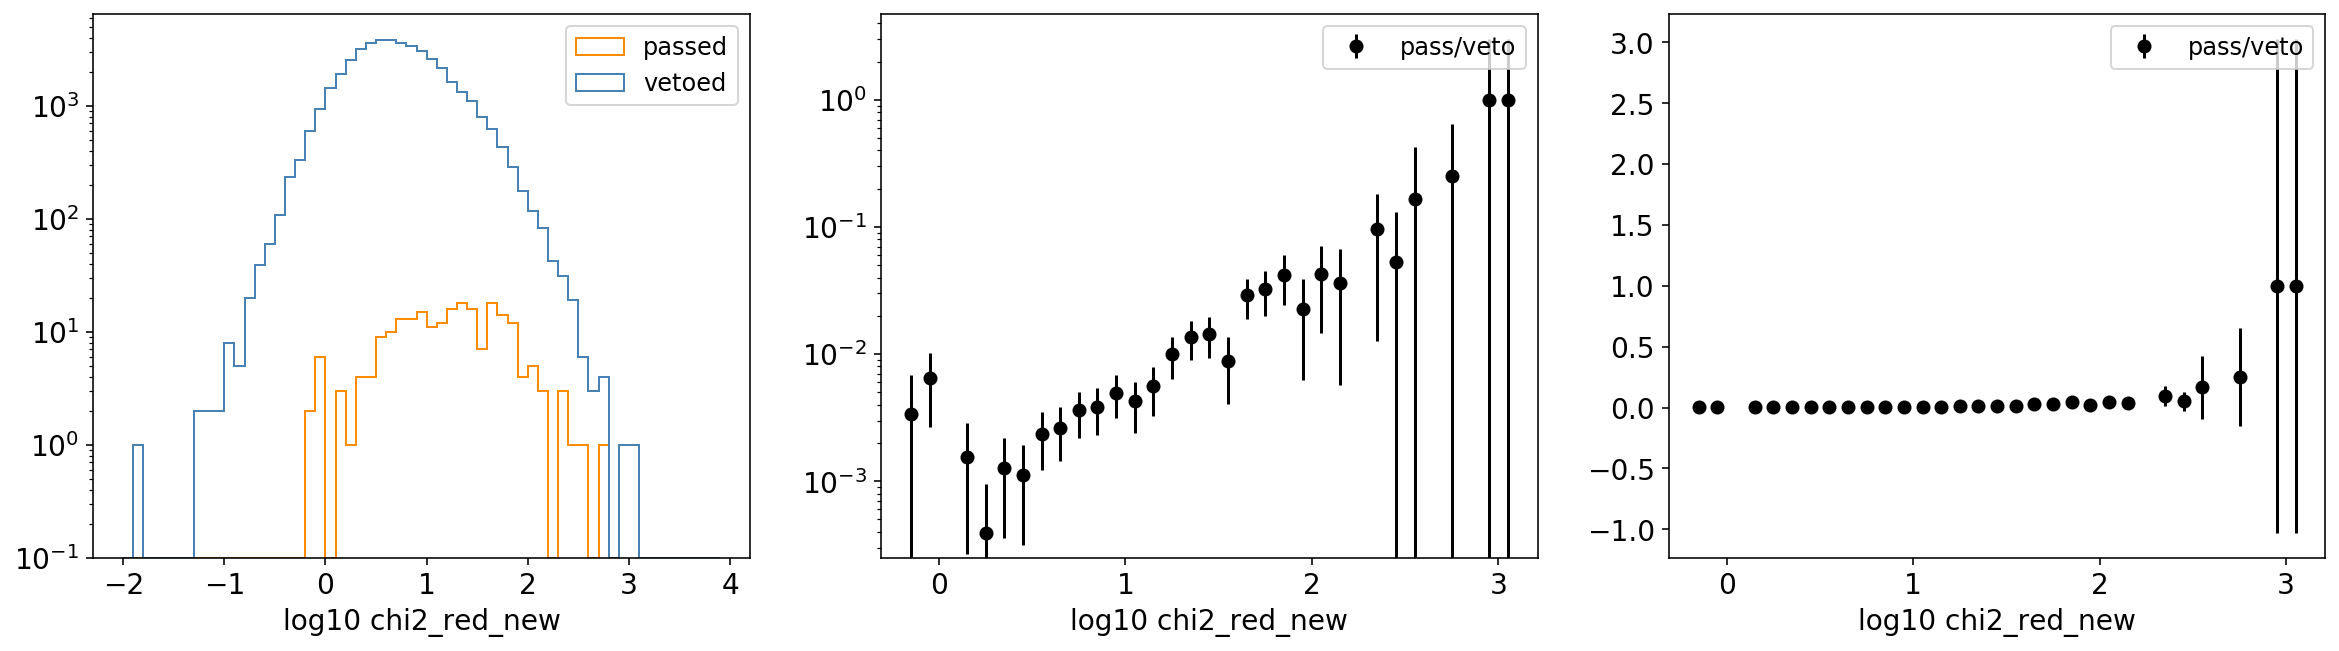

In [19]:
make_dataplots(np.log10(chi2_red_new_data_burn),np.arange(-2,4,0.1),'log10 chi2_red_new') # new model 

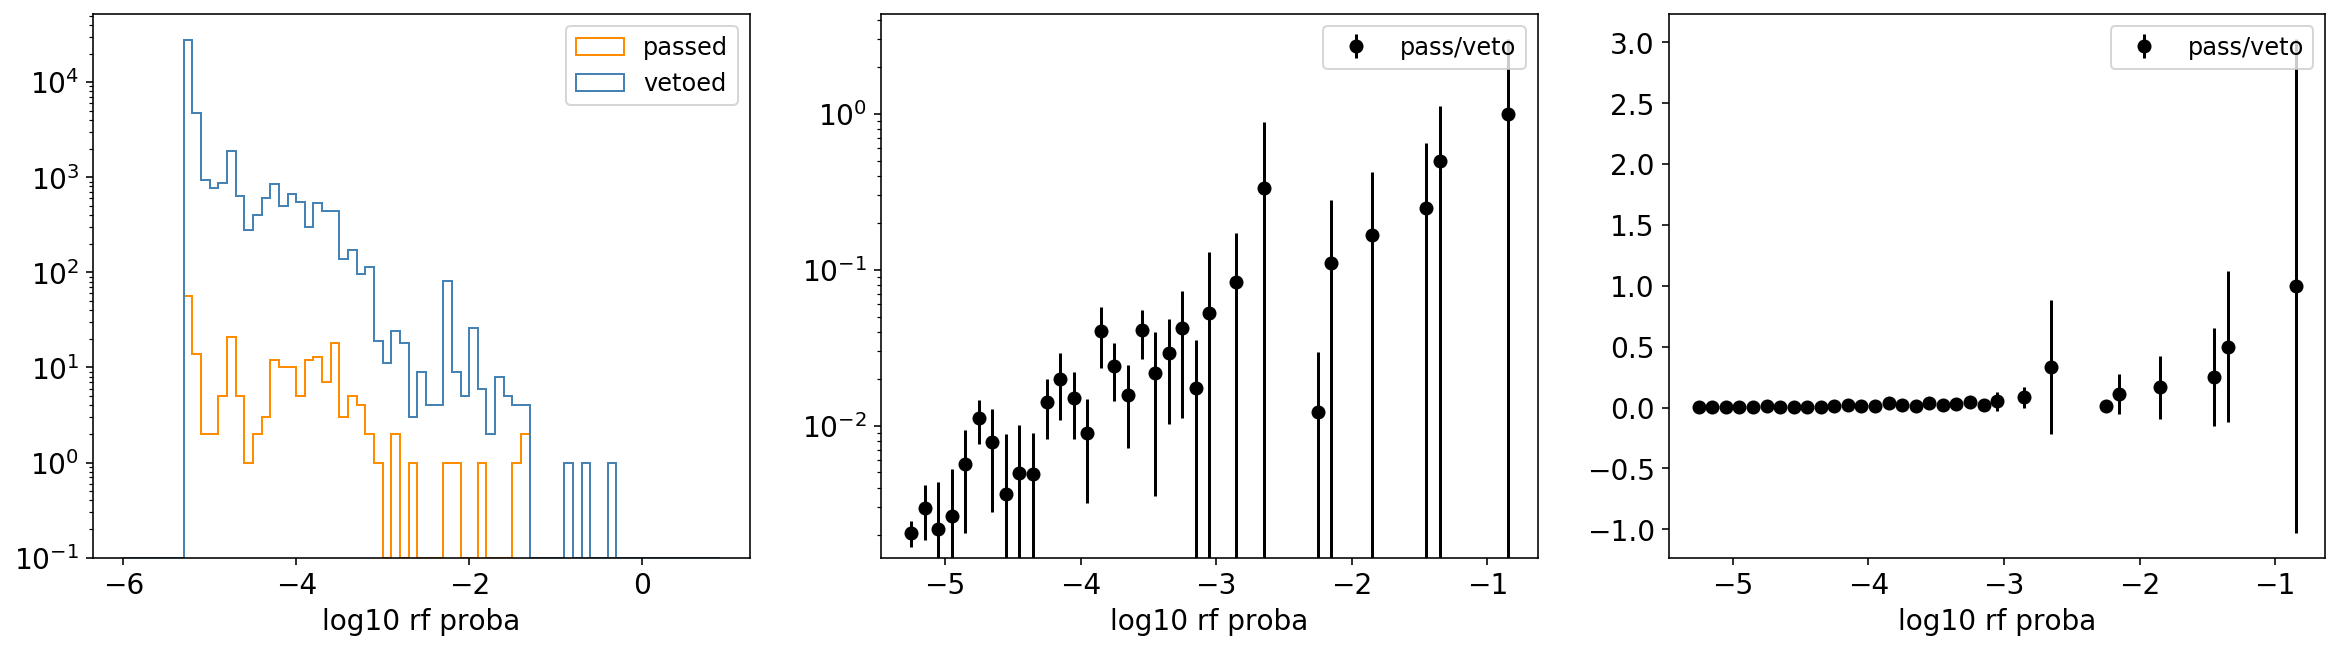

In [23]:
make_dataplots(np.log10(probability_data),np.arange(-6,1,0.1),'log10 rf proba')

# stochasticity cuts

In [14]:
# ineff < 0.01: 
# chi2_red_new_control = 2.
# chi2_red_new_cut = 2.5

# ineff < 0.001:
chi2_red_new_control = 1.5
chi2_red_new_cut = 1.8

In [15]:
print(np.sum(weight_numu_astro[np.log10(chi2_red_new_numu)>chi2_red_new_cut]))
print(np.sum(weight_corsika[np.log10(chi2_red_new_corsika)>chi2_red_new_cut]))

1.1228167920215353
1243.7245527910245


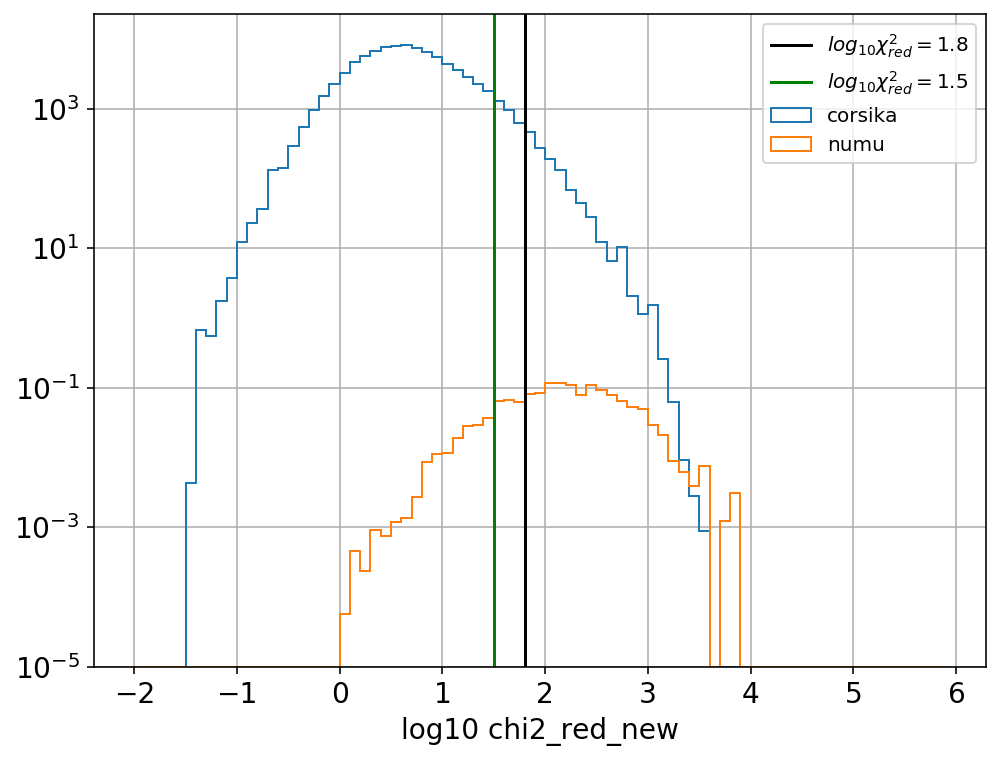

In [16]:
plt.figure(figsize=(8,6))

plt.hist(np.log10(chi2_red_new_corsika),weights=weight_corsika,bins=np.arange(-2,6,0.1),log=True,histtype='step',label='corsika',bottom=1e-5)
plt.hist(np.log10(chi2_red_new_numu),weights=weight_numu_astro,bins=np.arange(-2,6,0.1),log=True,histtype='step',label='numu',bottom=1e-5)
plt.axvline(chi2_red_new_cut,label=r'$log_{10}\chi^2_{red}=$'+str(chi2_red_new_cut),color='black')
plt.axvline(chi2_red_new_control,label=r'$log_{10}\chi^2_{red}=$'+str(chi2_red_new_control),color='green')
plt.legend(prop={'size': 10})
plt.grid(True,which='both',zorder=0)
plt.xlabel('log10 chi2_red_new')
plt.show()

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


[[ 0.00462905 -0.00448025]
 [-0.00448025  0.00484273]]


/Users/yang/miniconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3370: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


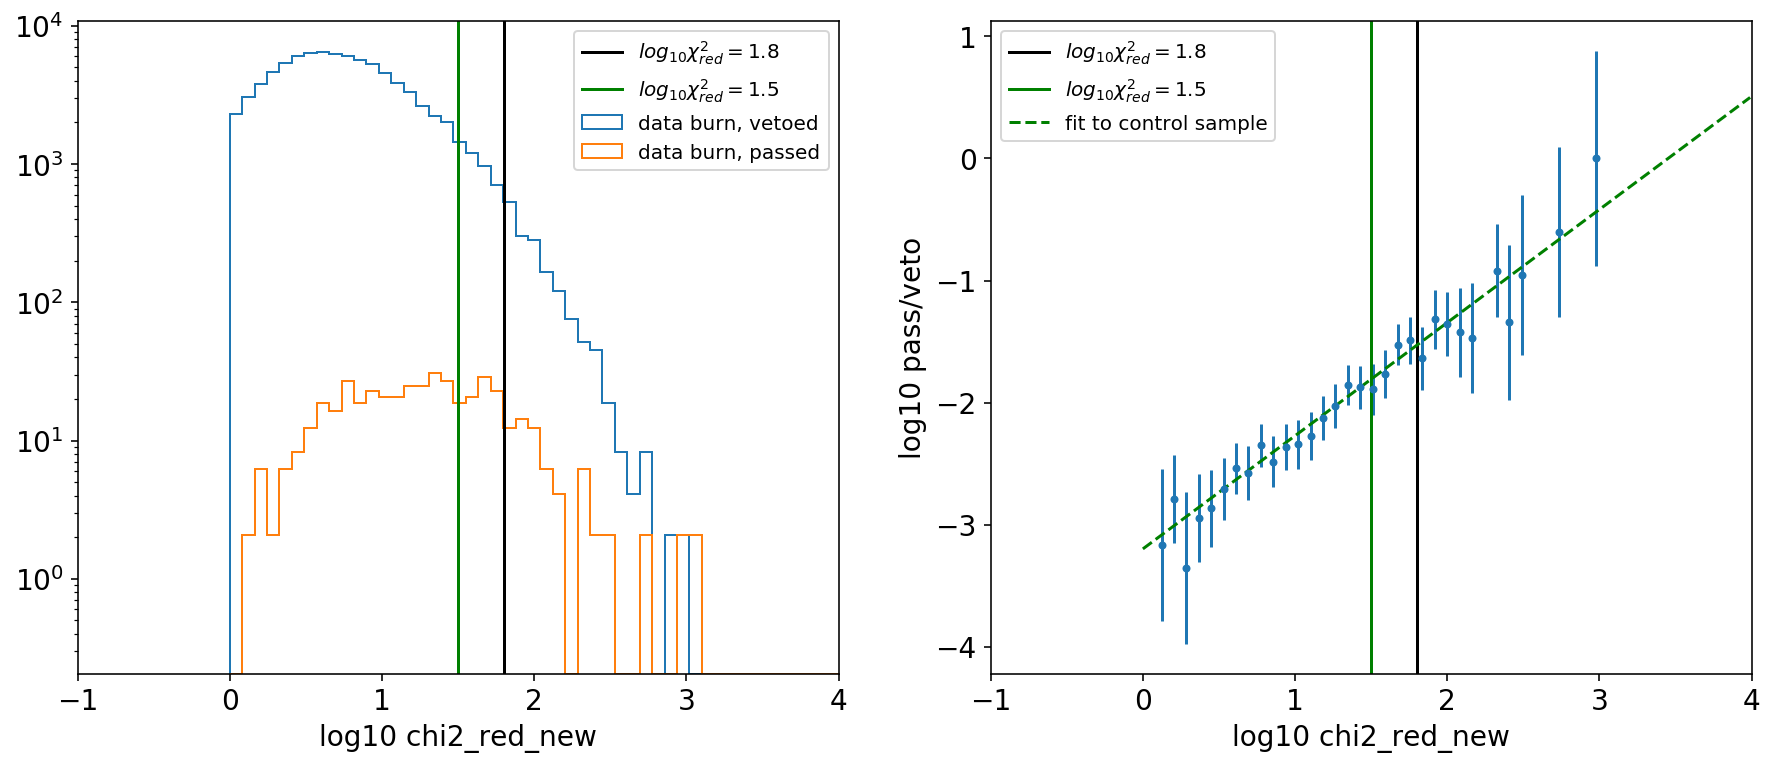

In [17]:
plt.figure(figsize=(15,6))
Nbins = 50
def sigma(x,y): # log10(x/y)
#     return np.sqrt(weight_data_burn[0]) * x/y*np.sqrt(1/x+1/y)
    return weight_data_burn[0]/np.log(10) * np.sqrt(1/x+1/y)

plt.subplot(121)
Bins = np.linspace(0,4,Nbins)
h_veto,b_,p_ = plt.hist(np.log10(chi2_red_new_data_burn)[vetoed_2_data_burn],bins=Bins,histtype='step',weights=weight_data_burn[vetoed_2_data_burn],label='data burn, vetoed',log=True)
h_pass,b_,p_ = plt.hist(np.log10(chi2_red_new_data_burn)[passed_2_data_burn],bins=Bins,histtype='step',weights=weight_data_burn[passed_2_data_burn],label='data burn, passed',log=True)
plt.axvline(chi2_red_new_cut,label=r'$log_{10}\chi^2_{red}=$'+str(chi2_red_new_cut),color='black')
plt.axvline(chi2_red_new_control,label=r'$log_{10}\chi^2_{red}=$'+str(chi2_red_new_control),color='green')
plt.xlabel('log10 chi2_red_new')
plt.xlim(-1,4)
plt.legend(prop={'size': 10})
b_ = (b_[1:]+b_[:-1])/2
b_=b_[h_pass>0]
h_veto=h_veto[h_pass>0]
h_pass=h_pass[h_pass>0]
sig_vp = sigma(h_pass,h_veto)

def f_control(x,a,b):
    return a*x + b
popt,pcov = curve_fit(f_control,b_[b_<=chi2_red_new_control],np.log10((h_pass/h_veto)[b_<=chi2_red_new_control]),sigma=sig_vp[b_<=chi2_red_new_control])
print(pcov)

plt.subplot(122)
plt.errorbar(b_,np.log10(h_pass/h_veto),fmt='.',yerr=sig_vp)
plt.axvline(chi2_red_new_cut,label=r'$log_{10}\chi^2_{red}=$'+str(chi2_red_new_cut),color='black')
plt.axvline(chi2_red_new_control,label=r'$log_{10}\chi^2_{red}=$'+str(chi2_red_new_control),color='green')
t = np.arange(0,4,0.01)
plt.plot(t,f_control(t,*popt),'--',color='g',label='fit to control sample')


# plt.yscale('log')
plt.xlabel('log10 chi2_red_new')
plt.ylabel('log10 pass/veto')
plt.xlim(-1,4)
plt.legend(prop={'size': 10})

plt.show()

In [18]:
a_upper = popt[0]+np.sqrt(pcov[0,0])
a_lower = popt[0]-np.sqrt(pcov[0,0])
b_upper = popt[1]+np.sqrt(pcov[1,1])
b_lower = popt[1]-np.sqrt(pcov[1,1])
# print(a_upper,a_lower,b_upper,b_lower)

# control region
CUT_stoch_high_IT_sig = (np.log10(chi2_red_new_data_burn) > chi2_red_new_control) & (np.log10(chi2_red_new_data_burn) < chi2_red_new_cut) & (passed_2_data_burn)  
CUT_stoch_high_IT_bg = (np.log10(chi2_red_new_data_burn) > chi2_red_new_control) & (np.log10(chi2_red_new_data_burn) < chi2_red_new_cut) & (vetoed_2_data_burn)  
CUT_stoch_low_IT_sig = (np.log10(chi2_red_new_data_burn) < chi2_red_new_control) & (passed_2_data_burn)  
CUT_stoch_low_IT_bg = (np.log10(chi2_red_new_data_burn) < chi2_red_new_control) & (vetoed_2_data_burn)  

d_11 = weight_data_burn[CUT_stoch_high_IT_bg]
d_12 = weight_data_burn[CUT_stoch_high_IT_sig]
d_21 = weight_data_burn[CUT_stoch_low_IT_bg]
d_22 = weight_data_burn[CUT_stoch_low_IT_sig]

# stoch_d_11 = np.log10(chi2_red_new_data_burn)[CUT_stoch_high_IT_bg]

d_11_err = np.sqrt(np.sum(weight_data_burn[CUT_stoch_high_IT_bg]**2))
d_12_err = np.sqrt(np.sum(weight_data_burn[CUT_stoch_high_IT_sig]**2))
d_21_err = np.sqrt(np.sum(weight_data_burn[CUT_stoch_low_IT_bg]**2))
d_22_err = np.sqrt(np.sum(weight_data_burn[CUT_stoch_low_IT_sig]**2))

df_control = pd.DataFrame({"Control Region": ["High Stoch", "Low Stoch"],
                   "IT vetoed": [np.round(np.sum(d_11),2), np.round(np.sum(d_21),2)], 
                   "IT passed": [np.round(np.sum(d_12),2), np.round(np.sum(d_22),2)]})
display(df_control)

print('expected bg in validation region (A\'):', np.round(np.sum(d_12),2),'+/-', np.round(d_12_err,2) )
# print('estimated bg in validation region (A\'):', np.round(np.sum(10**f_control(chi2_red_new_control,*popt)*d_11),2) )
print('estimated bg in validation region (A\'):', np.round(np.sum(10**f_control(np.log10(chi2_red_new_data_burn)[CUT_stoch_high_IT_bg],*popt)*d_11),2) )


print('stat uncertainty, upper:',np.round(np.sum(10**f_control(np.log10(chi2_red_new_data_burn)[CUT_stoch_high_IT_bg],a_upper,b_upper)*d_11),2))
# print('syst: upper lower:',np.round(np.sum(10**f_control(np.log10(chi2_red_new_data_burn)[CUT_stoch_high_IT_bg],a_upper,b_lower)*d_11),2))
# print('syst: lower upper:',np.round(np.sum(10**f_control(np.log10(chi2_red_new_data_burn)[CUT_stoch_high_IT_bg],a_lower,b_upper)*d_11),2))
print('stat uncertainty, lower:',np.round(np.sum(10**f_control(np.log10(chi2_red_new_data_burn)[CUT_stoch_high_IT_bg],a_lower,b_lower)*d_11),2))


,Control Region,IT vetoed,IT passed
0,High Stoch,3790.03,80.33
1,Low Stoch,85162.37,315.15


expected bg in validation region (A'): 80.33 +/- 12.86
estimated bg in validation region (A'): 78.61
stat uncertainty, upper: 119.36
stat uncertainty, lower: 51.78


[[ 0.00239256 -0.00269588]
 [-0.00269588  0.00343759]]


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


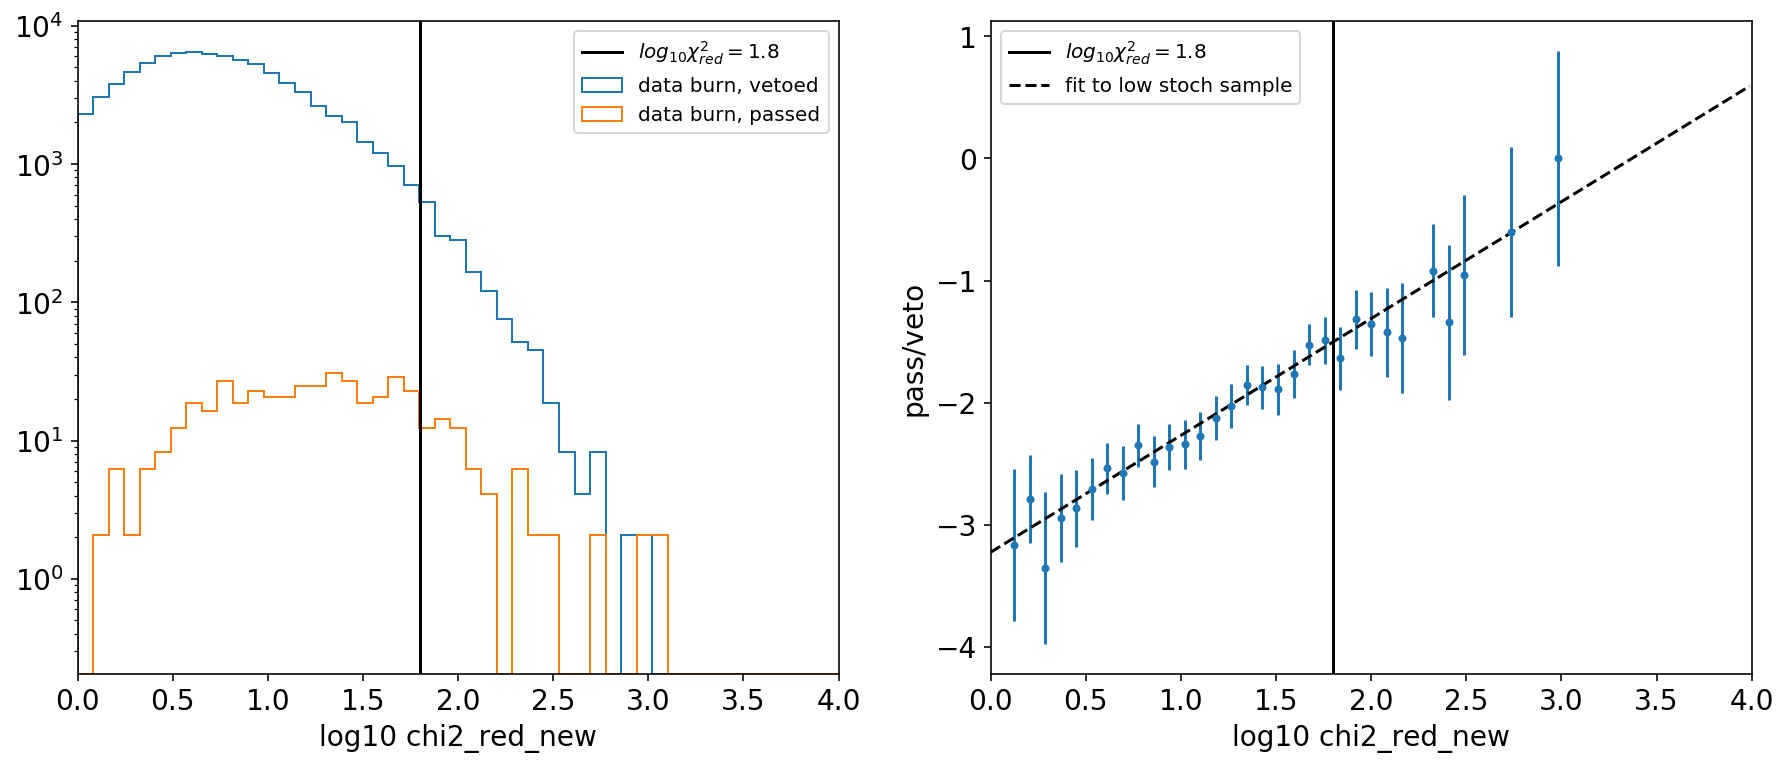

In [19]:
plt.figure(figsize=(15,6))
Nbins = 50
def sigma(x,y): # log10(x/y)
#     return np.sqrt(weight_data_burn[0]) * x/y*np.sqrt(1/x+1/y)
    return weight_data_burn[0]/np.log(10) * np.sqrt(1/x+1/y)

plt.subplot(121)
Bins = np.linspace(0,4,Nbins)
h_veto,b_,p_ = plt.hist(np.log10(chi2_red_new_data_burn)[vetoed_2_data_burn],bins=Bins,histtype='step',weights=weight_data_burn[vetoed_2_data_burn],label='data burn, vetoed',log=True)
h_pass,b_,p_ = plt.hist(np.log10(chi2_red_new_data_burn)[passed_2_data_burn],bins=Bins,histtype='step',weights=weight_data_burn[passed_2_data_burn],label='data burn, passed',log=True)
plt.axvline(chi2_red_new_cut,label=r'$log_{10}\chi^2_{red}=$'+str(chi2_red_new_cut),color='black')
plt.xlabel('log10 chi2_red_new')
plt.xlim(0,4)
plt.legend(prop={'size': 10})
b_ = (b_[1:]+b_[:-1])/2
b_=b_[h_pass>0]
h_veto=h_veto[h_pass>0]
h_pass=h_pass[h_pass>0]
sig_vp = sigma(h_pass,h_veto)

plt.subplot(122)
plt.errorbar(b_,np.log10(h_pass/h_veto),fmt='.',yerr=sig_vp)
plt.axvline(chi2_red_new_cut,label=r'$log_{10}\chi^2_{red}=$'+str(chi2_red_new_cut),color='black')
# plt.axvline(chi2_red_new_control,label=r'$log_{10}\chi^2_{red}=$'+str(chi2_red_new_control),color='green')
t = np.arange(0,4,0.01)

def f_full(x,a,b):
    return a*x + b
popt,pcov = curve_fit(f_full,b_[b_<=chi2_red_new_cut],np.log10((h_pass/h_veto)[b_<=chi2_red_new_cut]),sigma=sig_vp[b_<=chi2_red_new_cut])
print(pcov)
plt.plot(t,f_full(t,*popt),'--',color='black',label='fit to low stoch sample')

# plt.yscale('log')
plt.xlabel('log10 chi2_red_new')
plt.ylabel('pass/veto')
plt.xlim(0,4)
plt.legend(prop={'size': 10})

plt.show()

In [20]:
# full region
CUT_stoch_sig_IT_sig = (np.log10(chi2_red_new_data_burn) > chi2_red_new_cut) & (passed_2_data_burn)  
CUT_stoch_sig_IT_bg = (np.log10(chi2_red_new_data_burn) > chi2_red_new_cut) & (vetoed_2_data_burn)  
CUT_stoch_bg_IT_sig = (np.log10(chi2_red_new_data_burn) < chi2_red_new_cut) & (passed_2_data_burn)  
CUT_stoch_bg_IT_bg = (np.log10(chi2_red_new_data_burn) < chi2_red_new_cut) & (vetoed_2_data_burn)  

d11 = weight_data_burn[CUT_stoch_sig_IT_bg]
d12 = weight_data_burn[CUT_stoch_sig_IT_sig]
d21 = weight_data_burn[CUT_stoch_bg_IT_bg]
d22 = weight_data_burn[CUT_stoch_bg_IT_sig]

stoch_d11 = np.log10(chi2_red_new_data_burn)[CUT_stoch_sig_IT_bg]

d11_err = np.sqrt(np.sum(weight_data_burn[CUT_stoch_sig_IT_bg]**2))
d12_err = np.sqrt(np.sum(weight_data_burn[CUT_stoch_sig_IT_sig]**2))
d21_err = np.sqrt(np.sum(weight_data_burn[CUT_stoch_bg_IT_bg]**2))
d22_err = np.sqrt(np.sum(weight_data_burn[CUT_stoch_bg_IT_sig]**2))

df_full = pd.DataFrame({"Full Region": ["High Stoch", "Low Stoch"],
                   "IT vetoed": [np.round(np.sum(d11),2), np.round(np.sum(d21),2)], 
                   "IT passed": [np.round(np.sum(d12),2), np.round(np.sum(d22),2)]})
display(df_full)

print('total events in signal region (A):', np.round(np.sum(d12),2),'+/-', np.round(d12_err,2) )
# print('estimated bg in signal region:',np.round(np.sum(10**f_full(chi2_red_new_cut,*popt)*d11),2))
print('estimated bg in signal region:',np.round(np.sum(10**f_full(np.log10(chi2_red_new_data_burn)[CUT_stoch_sig_IT_bg],*popt)*d11),2))

a_upper = popt[0]+np.sqrt(pcov[0,0])
a_lower = popt[0]-np.sqrt(pcov[0,0])
b_upper = popt[1]+np.sqrt(pcov[1,1])
b_lower = popt[1]-np.sqrt(pcov[1,1])
# print(a_upper,a_lower,b_upper,b_lower)


print('stat uncertainty, upper:',np.round(np.sum(10**f_full(np.log10(chi2_red_new_data_burn)[CUT_stoch_sig_IT_bg],a_upper,b_upper)*d11),2))
# print('stat: upper lower:',np.round(np.sum(10**f_full(np.log10(chi2_red_new_data_burn)[CUT_stoch_sig_IT_bg],a_upper,b_lower)*d11),2))
# print('stat: lower upper:',np.round(np.sum(10**f_full(np.log10(chi2_red_new_data_burn)[CUT_stoch_sig_IT_bg],a_lower,b_upper)*d11),2))
print('stat uncertainty, lower:',np.round(np.sum(10**f_full(np.log10(chi2_red_new_data_burn)[CUT_stoch_sig_IT_bg],a_lower,b_lower)*d11),2))

,Full Region,IT vetoed,IT passed
0,High Stoch,1579.87,65.91
1,Low Stoch,88952.40,395.48


total events in signal region (A): 65.91 +/- 11.65
estimated bg in signal region: 86.29
stat uncertainty, upper: 125.31
stat uncertainty, lower: 59.46


# Attempt: use random forest/BDT score as stochasticity

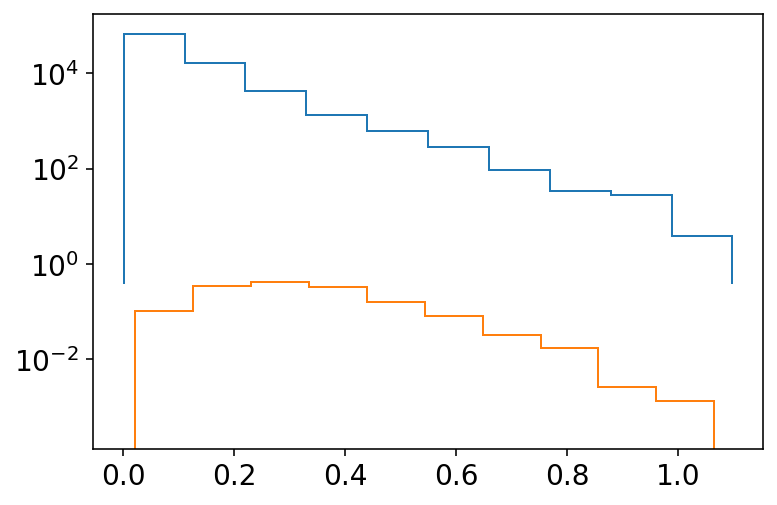

In [21]:
plt.hist(chi2_red_corsika,weights=weight_corsika,log=True,histtype='step')
plt.hist(chi2_red_numu,weights=weight_numu_astro,log=True,histtype='step')
plt.show()

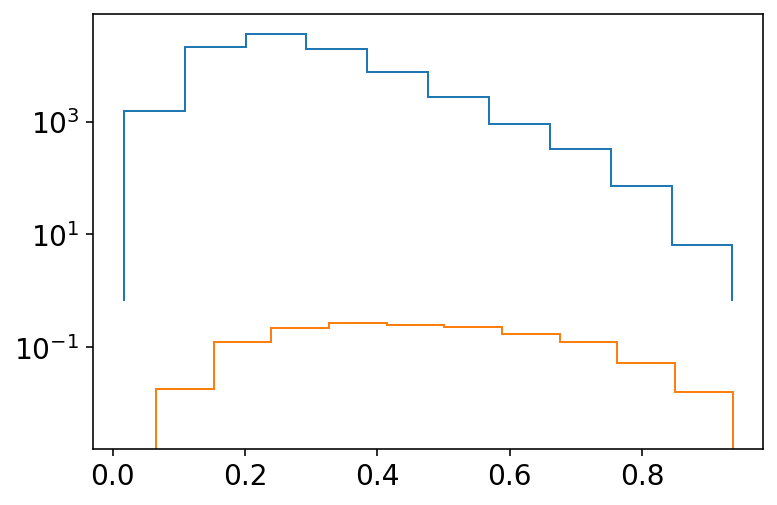

In [22]:
plt.hist(np.log10(PeakOverMean_corsika),weights=weight_corsika,log=True,histtype='step')
plt.hist(np.log10(PeakOverMean_numu),weights=weight_numu_astro,log=True,histtype='step')
plt.show()

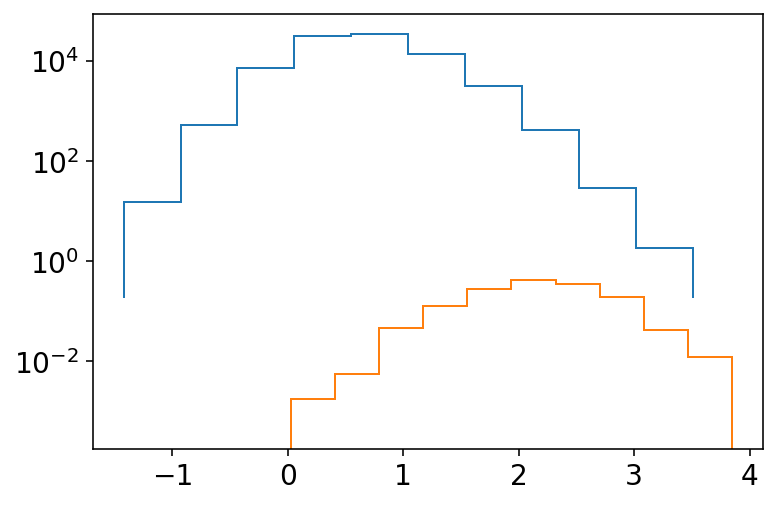

In [23]:
plt.hist(np.log10(chi2_red_new_corsika),weights=weight_corsika,log=True,histtype='step')
plt.hist(np.log10(chi2_red_new_numu),weights=weight_numu_astro,log=True,histtype='step')
plt.show()